# Data Quality Exploration for CRISP Pipeline

This notebook helps you understand and assess your OMOP CDM data quality before running the CRISP pipeline.

**Purpose:**
- Examine data completeness and quality
- Identify potential issues before processing
- Generate quality metrics and visualizations

**Expected runtime:** ~5 minutes for 1000 patients

## Part 1: Setup and Data Loading

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configure visualization
plt.style.use('default')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


In [15]:
# Load OMOP data tables
data_dir = Path('../data')

# Define required tables
required_tables = [
    'PERSON', 'VISIT_OCCURRENCE', 'CONDITION_OCCURRENCE',
    'PROCEDURE_OCCURRENCE', 'DRUG_EXPOSURE', 'MEASUREMENT',
    'OBSERVATION'
]

# Load available tables
tables = {}
missing_tables = []

for table_name in required_tables:
    file_path = data_dir / f"{table_name}.csv"
    if file_path.exists():
        print(f"Loading {table_name}...", end=' ')
        tables[table_name] = pd.read_csv(file_path)
        print(f"[DONE] ({len(tables[table_name]):,} rows)")
    else:
        missing_tables.append(table_name)
        print(f"[WARNING]  {table_name} not found")

if missing_tables:
    print(f"\n[WARNING]  Missing {len(missing_tables)} tables: {missing_tables}")
else:
    print(f"\n[OK] All {len(required_tables)} required tables loaded successfully")

Loading PERSON... ✓ (538 rows)
Loading VISIT_OCCURRENCE... ✓ (55,185 rows)
Loading CONDITION_OCCURRENCE... ✓ (196,241 rows)
Loading PROCEDURE_OCCURRENCE... ✓ (47,395 rows)
Loading DRUG_EXPOSURE... ✓ (204,252 rows)
Loading MEASUREMENT... ✓ (1,944,155 rows)
Loading OBSERVATION... ✓ (241,604 rows)

✅ All 7 required tables loaded successfully


## Part 2: Basic Quality Checks

In [16]:
# Table sizes and basic statistics
table_stats = []

for name, df in tables.items():
    stats = {
        'Table': name,
        'Rows': len(df),
        'Columns': len(df.columns),
        'Memory (MB)': df.memory_usage(deep=True).sum() / 1024**2,
        'Null %': (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100) if len(df) > 0 else 0
    }
    table_stats.append(stats)

stats_df = pd.DataFrame(table_stats).round(2)
stats_df = stats_df.sort_values('Rows', ascending=False)

print("[STATS] Table Statistics Summary:")
print("="*60)
print(stats_df.to_string(index=False))
print(f"\nTotal rows across all tables: {stats_df['Rows'].sum():,}")
print(f"Total memory usage: {stats_df['Memory (MB)'].sum():.1f} MB")

📊 Table Statistics Summary:
               Table    Rows  Columns  Memory (MB)  Null %
         MEASUREMENT 1944155       20       612.38   36.41
         OBSERVATION  241604       18        62.44   45.02
       DRUG_EXPOSURE  204252       23        89.27   42.52
CONDITION_OCCURRENCE  196241       16        66.62   37.33
    VISIT_OCCURRENCE   55185       17        20.49   34.22
PROCEDURE_OCCURRENCE   47395       14        10.80   27.30
              PERSON     538       18         0.11   33.19

Total rows across all tables: 2,689,370
Total memory usage: 862.1 MB


In [17]:
# Check for missing values in critical columns
print("[CHECK] Missing Values in Critical Columns:")
print("="*60)

critical_columns = {
    'PERSON': ['person_id', 'gender_concept_id', 'year_of_birth'],
    'VISIT_OCCURRENCE': ['visit_occurrence_id', 'person_id', 'visit_start_date'],
    'MEASUREMENT': ['measurement_id', 'person_id', 'measurement_concept_id'],
    'CONDITION_OCCURRENCE': ['condition_occurrence_id', 'person_id', 'condition_concept_id']
}

for table_name, columns in critical_columns.items():
    if table_name in tables:
        df = tables[table_name]
        print(f"\n{table_name}:")
        for col in columns:
            if col in df.columns:
                null_count = df[col].isnull().sum()
                null_pct = (null_count / len(df) * 100) if len(df) > 0 else 0
                if null_count > 0:
                    print(f"  [WARNING]  {col}: {null_count:,} nulls ({null_pct:.1f}%)")
                else:
                    print(f"  [DONE] {col}: no nulls")

🔍 Missing Values in Critical Columns:

PERSON:
  ✓ person_id: no nulls
  ✓ gender_concept_id: no nulls
  ✓ year_of_birth: no nulls

VISIT_OCCURRENCE:
  ✓ visit_occurrence_id: no nulls
  ✓ person_id: no nulls
  ✓ visit_start_date: no nulls

MEASUREMENT:
  ✓ measurement_id: no nulls
  ✓ person_id: no nulls
  ✓ measurement_concept_id: no nulls

CONDITION_OCCURRENCE:
  ✓ condition_occurrence_id: no nulls
  ✓ person_id: no nulls
  ✓ condition_concept_id: no nulls


In [18]:
# Check for duplicate person_ids
if 'PERSON' in tables:
    person_df = tables['PERSON']
    total_persons = len(person_df)
    unique_persons = person_df['person_id'].nunique()
    duplicates = total_persons - unique_persons
    
    print("[USERS] Person ID Analysis:")
    print("="*60)
    print(f"Total person records: {total_persons:,}")
    print(f"Unique person IDs: {unique_persons:,}")
    
    if duplicates > 0:
        print(f"[WARNING]  Found {duplicates} duplicate person_id entries")
        # Show duplicate IDs
        dup_ids = person_df[person_df.duplicated('person_id', keep=False)]['person_id'].value_counts().head()
        print("\nTop duplicate person_ids:")
        print(dup_ids)
    else:
        print("[OK] No duplicate person_ids found")

👥 Person ID Analysis:
Total person records: 538
Unique person IDs: 538
✅ No duplicate person_ids found


In [19]:
# Foreign key validation - Check if all persons in other tables exist in PERSON
if 'PERSON' in tables:
    person_ids = set(tables['PERSON']['person_id'].unique())
    
    print("[LINK] Foreign Key Validation (person_id):")
    print("="*60)
    
    for table_name, df in tables.items():
        if table_name != 'PERSON' and 'person_id' in df.columns:
            table_person_ids = set(df['person_id'].unique())
            orphaned = table_person_ids - person_ids
            
            if orphaned:
                print(f"[WARNING]  {table_name}: {len(orphaned)} person_ids not found in PERSON table")
            else:
                print(f"[DONE] {table_name}: All person_ids valid")

🔗 Foreign Key Validation (person_id):
✓ VISIT_OCCURRENCE: All person_ids valid
✓ CONDITION_OCCURRENCE: All person_ids valid
✓ PROCEDURE_OCCURRENCE: All person_ids valid
✓ DRUG_EXPOSURE: All person_ids valid
✓ MEASUREMENT: All person_ids valid
✓ OBSERVATION: All person_ids valid


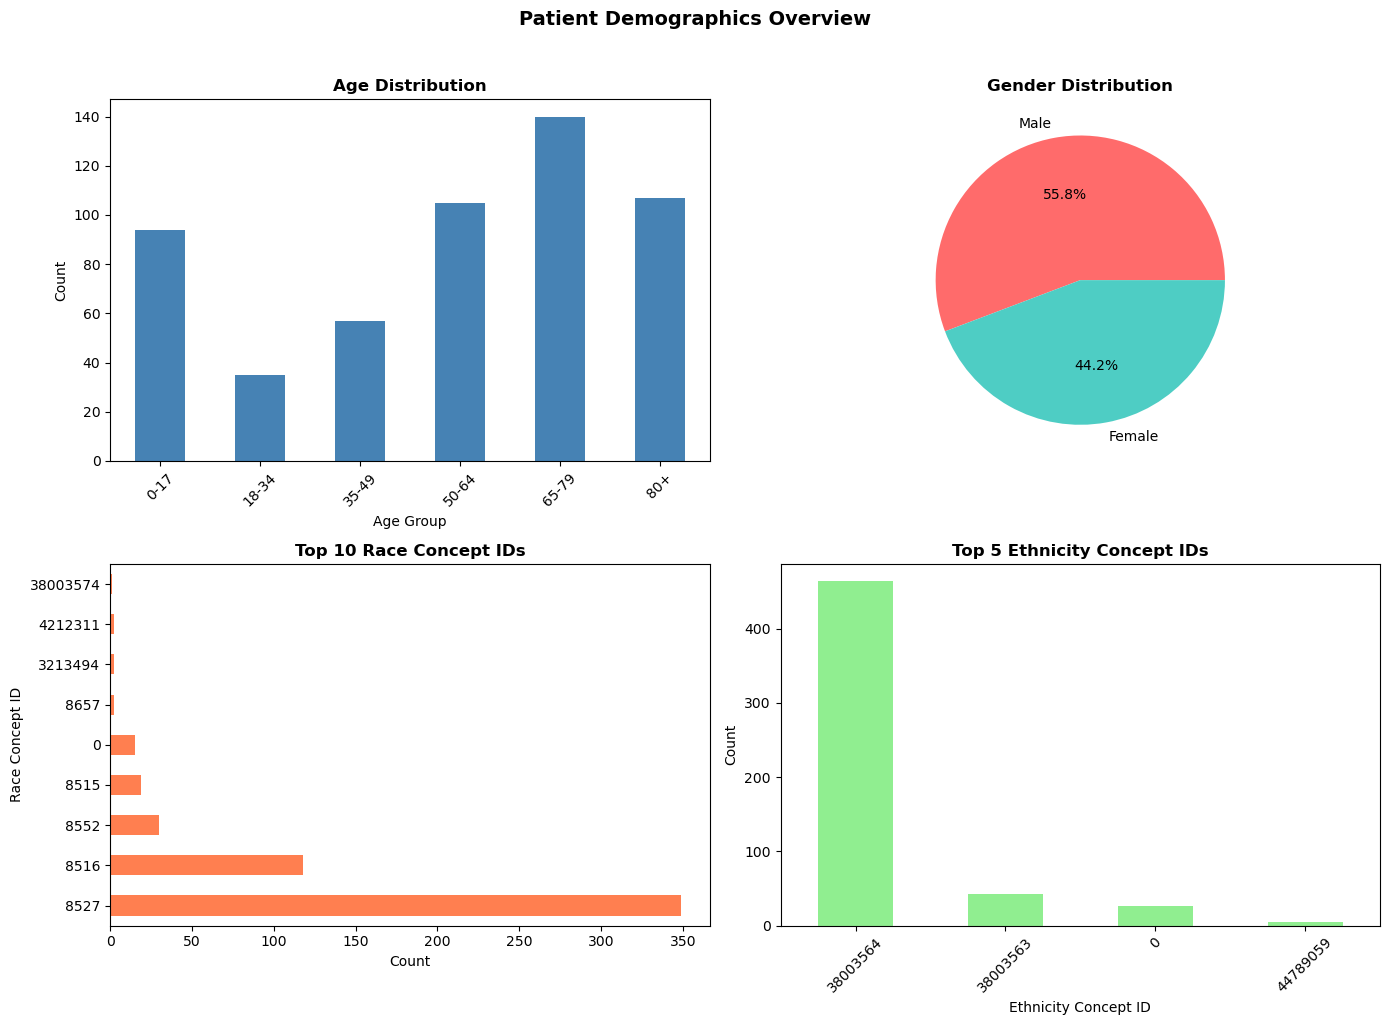

In [20]:
# Patient Demographics Visualization
if 'PERSON' in tables:
    person_df = tables['PERSON'].copy()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Age distribution
    if 'year_of_birth' in person_df.columns:
        current_year = pd.Timestamp.now().year
        person_df['age'] = current_year - person_df['year_of_birth']
        person_df['age_group'] = pd.cut(person_df['age'], 
                                        bins=[0, 18, 35, 50, 65, 80, 120],
                                        labels=['0-17', '18-34', '35-49', '50-64', '65-79', '80+'])
        age_counts = person_df['age_group'].value_counts().sort_index()
        age_counts.plot(kind='bar', ax=ax1, color='steelblue')
        ax1.set_title('Age Distribution', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Age Group')
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)
    
    # Gender distribution
    if 'gender_concept_id' in person_df.columns:
        gender_map = {8507: 'Male', 8532: 'Female', 0: 'Unknown'}
        person_df['gender'] = person_df['gender_concept_id'].map(gender_map).fillna('Other')
        gender_counts = person_df['gender'].value_counts()
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFA07A']
        wedges, texts, autotexts = ax2.pie(gender_counts, labels=gender_counts.index, 
                                            autopct='%1.1f%%', colors=colors[:len(gender_counts)])
        ax2.set_title('Gender Distribution', fontsize=12, fontweight='bold')
    
    # Race distribution
    if 'race_concept_id' in person_df.columns:
        race_counts = person_df['race_concept_id'].value_counts().head(10)
        race_counts.plot(kind='barh', ax=ax3, color='coral')
        ax3.set_title('Top 10 Race Concept IDs', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Count')
        ax3.set_ylabel('Race Concept ID')
    
    # Ethnicity distribution
    if 'ethnicity_concept_id' in person_df.columns:
        ethnicity_counts = person_df['ethnicity_concept_id'].value_counts().head(5)
        ethnicity_counts.plot(kind='bar', ax=ax4, color='lightgreen')
        ax4.set_title('Top 5 Ethnicity Concept IDs', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Ethnicity Concept ID')
        ax4.set_ylabel('Count')
        ax4.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Patient Demographics Overview', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

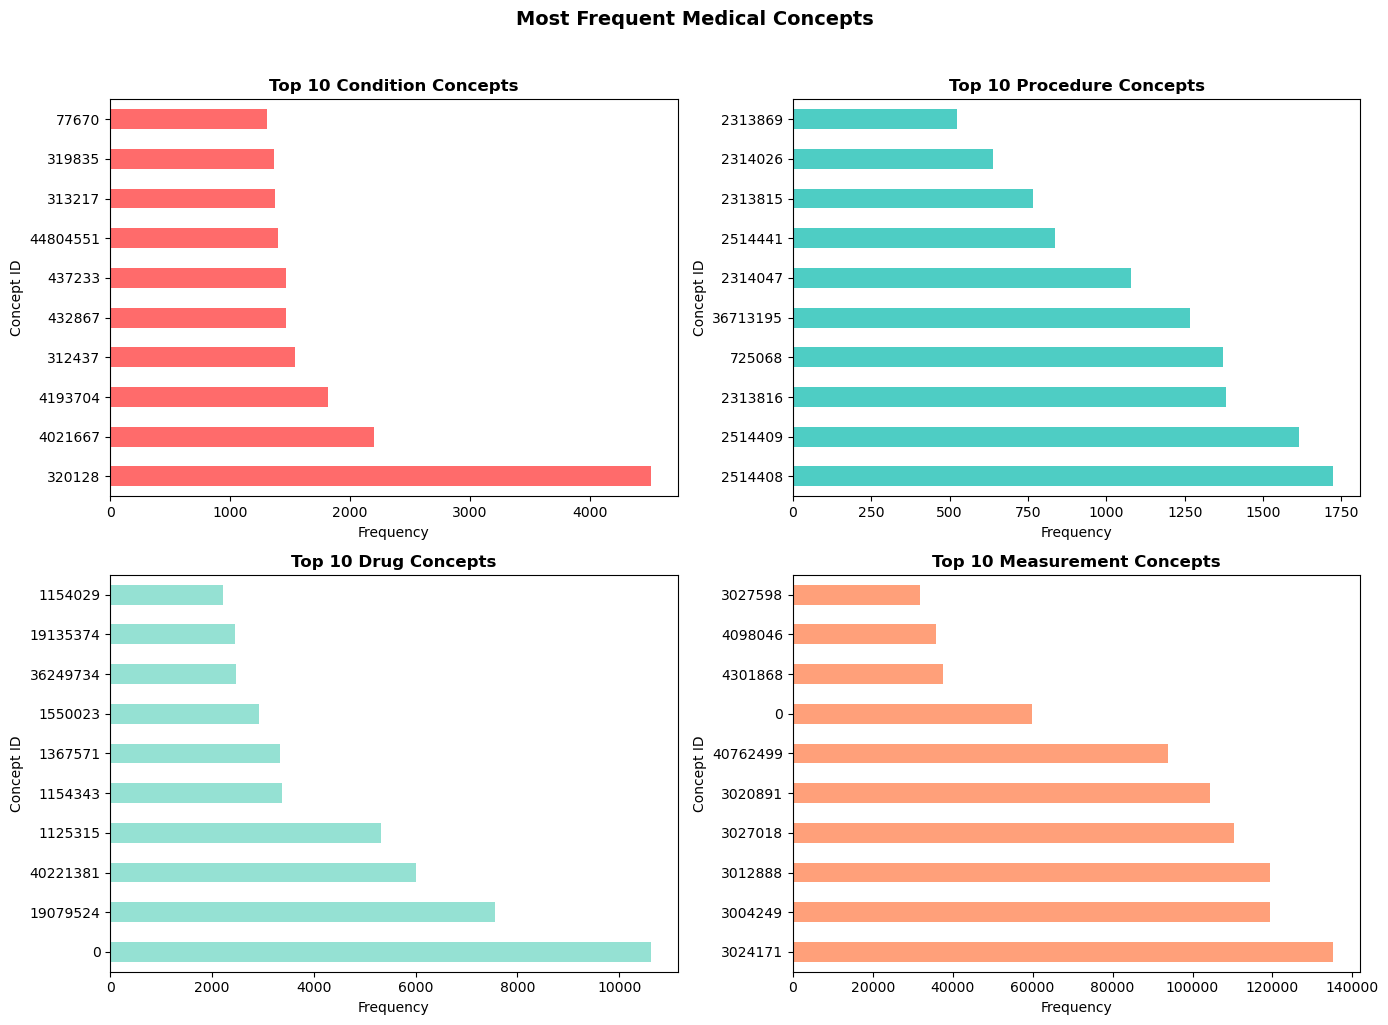

In [21]:
# Top Medical Concepts Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Top conditions
if 'CONDITION_OCCURRENCE' in tables:
    top_conditions = tables['CONDITION_OCCURRENCE']['condition_concept_id'].value_counts().head(10)
    top_conditions.plot(kind='barh', ax=ax1, color='#FF6B6B')
    ax1.set_title('Top 10 Condition Concepts', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Concept ID')

# Top procedures
if 'PROCEDURE_OCCURRENCE' in tables:
    top_procedures = tables['PROCEDURE_OCCURRENCE']['procedure_concept_id'].value_counts().head(10)
    top_procedures.plot(kind='barh', ax=ax2, color='#4ECDC4')
    ax2.set_title('Top 10 Procedure Concepts', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Concept ID')

# Top drugs
if 'DRUG_EXPOSURE' in tables:
    top_drugs = tables['DRUG_EXPOSURE']['drug_concept_id'].value_counts().head(10)
    top_drugs.plot(kind='barh', ax=ax3, color='#95E1D3')
    ax3.set_title('Top 10 Drug Concepts', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Concept ID')

# Top measurements
if 'MEASUREMENT' in tables:
    top_measurements = tables['MEASUREMENT']['measurement_concept_id'].value_counts().head(10)
    top_measurements.plot(kind='barh', ax=ax4, color='#FFA07A')
    ax4.set_title('Top 10 Measurement Concepts', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Frequency')
    ax4.set_ylabel('Concept ID')

plt.suptitle('Most Frequent Medical Concepts', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

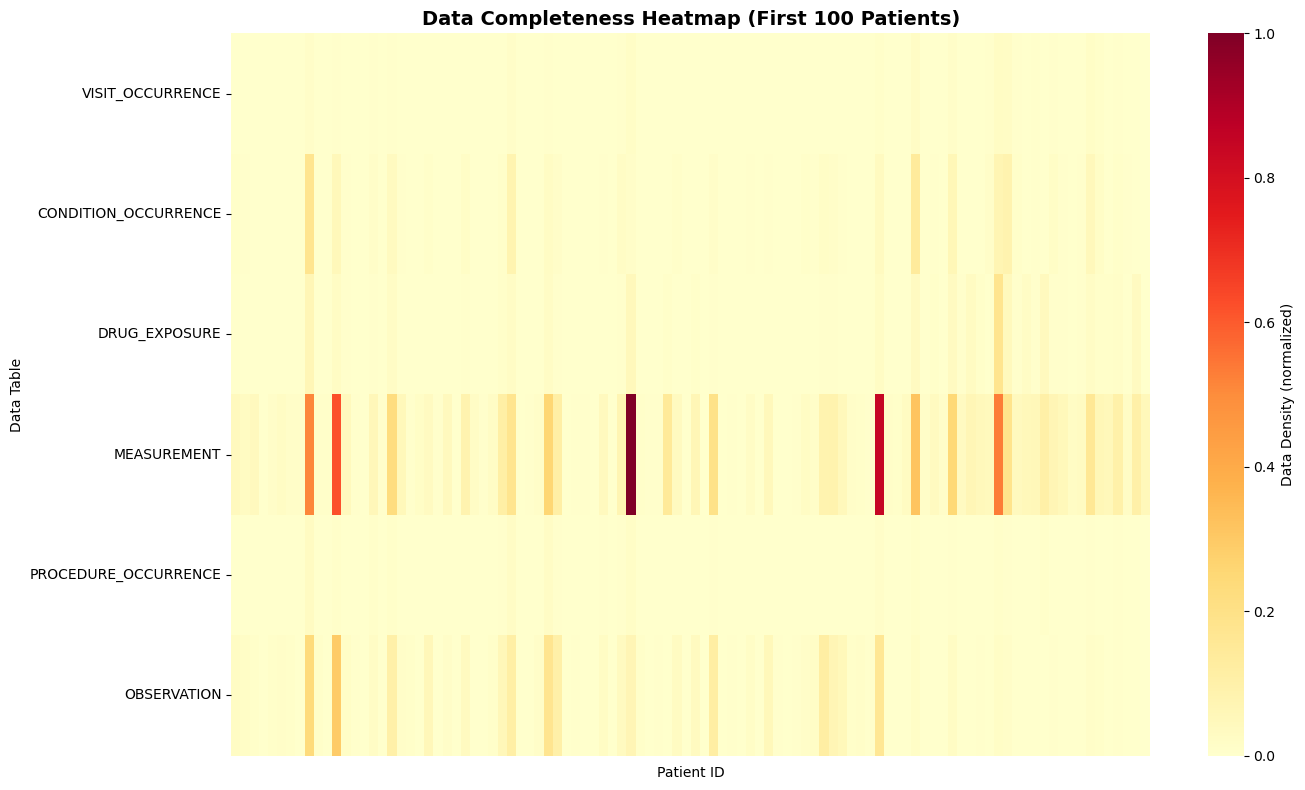

📊 Data Completeness Summary (per patient average):
VISIT_OCCURRENCE.............. 121.4 records, 100/100 patients
CONDITION_OCCURRENCE.......... 537.0 records, 100/100 patients
DRUG_EXPOSURE................. 408.3 records, 100/100 patients
MEASUREMENT................... 3575.0 records, 100/100 patients
PROCEDURE_OCCURRENCE.......... 129.0 records, 99/100 patients
OBSERVATION................... 1082.1 records, 98/100 patients


In [22]:
# Data Completeness per Patient
if 'PERSON' in tables:
    person_ids = tables['PERSON']['person_id'].unique()[:100]  # Sample first 100 patients
    
    patient_data_counts = []
    
    for pid in person_ids:
        counts = {'person_id': pid}
        
        for table_name in ['VISIT_OCCURRENCE', 'CONDITION_OCCURRENCE', 'DRUG_EXPOSURE', 
                          'MEASUREMENT', 'PROCEDURE_OCCURRENCE', 'OBSERVATION']:
            if table_name in tables and 'person_id' in tables[table_name].columns:
                counts[table_name] = len(tables[table_name][tables[table_name]['person_id'] == pid])
            else:
                counts[table_name] = 0
        
        patient_data_counts.append(counts)
    
    patient_df = pd.DataFrame(patient_data_counts)
    
    # Create heatmap of data density
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Prepare data for heatmap
    heatmap_data = patient_df.drop('person_id', axis=1).T
    
    # Normalize to 0-1 scale for better visualization
    heatmap_data_norm = (heatmap_data - heatmap_data.min().min()) / (heatmap_data.max().max() - heatmap_data.min().min())
    
    sns.heatmap(heatmap_data_norm, 
               cmap='YlOrRd',
               cbar_kws={'label': 'Data Density (normalized)'},
               xticklabels=False,
               yticklabels=heatmap_data.index,
               ax=ax)
    
    ax.set_title(f'Data Completeness Heatmap (First {len(person_ids)} Patients)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Patient ID')
    ax.set_ylabel('Data Table')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("[STATS] Data Completeness Summary (per patient average):")
    print("="*60)
    for col in patient_df.columns[1:]:
        avg_records = patient_df[col].mean()
        patients_with_data = (patient_df[col] > 0).sum()
        print(f"{col:.<30} {avg_records:.1f} records, {patients_with_data}/{len(person_ids)} patients")

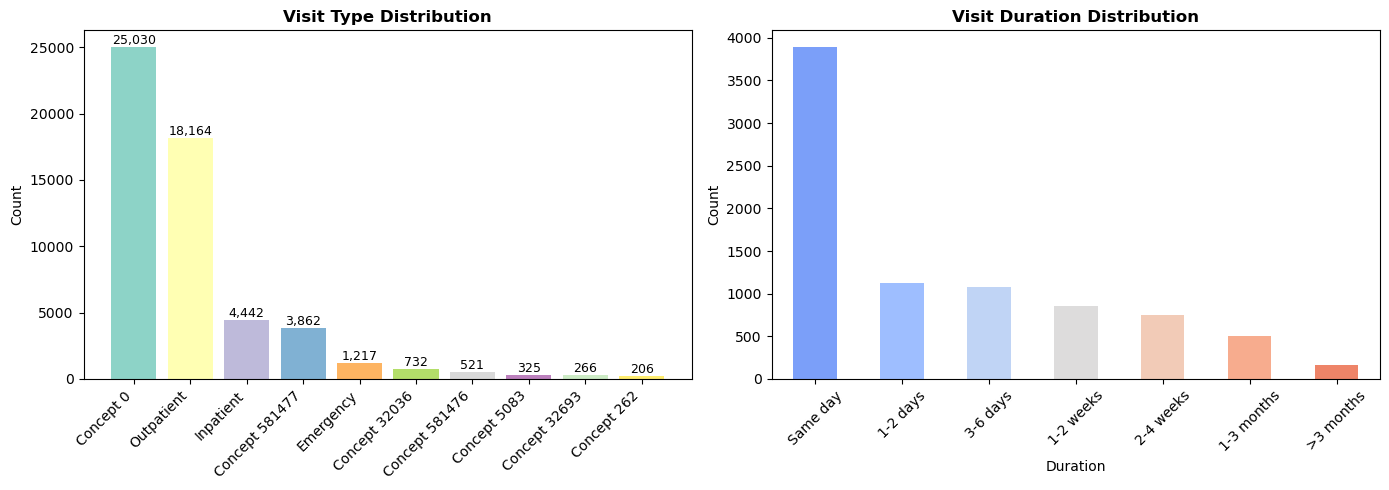

In [23]:
# Visit Type Distribution
if 'VISIT_OCCURRENCE' in tables:
    visit_df = tables['VISIT_OCCURRENCE'].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Visit concept distribution
    if 'visit_concept_id' in visit_df.columns:
        visit_types = visit_df['visit_concept_id'].value_counts().head(10)
        
        # Common visit type mapping
        visit_map = {
            9201: 'Inpatient',
            9202: 'Outpatient',
            9203: 'Emergency',
            32037: 'ICU',
            581379: 'ICU Admission'
        }
        
        visit_labels = [visit_map.get(vid, f'Concept {vid}') for vid in visit_types.index]
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(visit_types)))
        bars = ax1.bar(range(len(visit_types)), visit_types.values, color=colors)
        ax1.set_xticks(range(len(visit_types)))
        ax1.set_xticklabels(visit_labels, rotation=45, ha='right')
        ax1.set_title('Visit Type Distribution', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Count')
        
        # Add value labels on bars
        for bar, value in zip(bars, visit_types.values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
    
    # Visit duration analysis
    if 'visit_start_date' in visit_df.columns and 'visit_end_date' in visit_df.columns:
        visit_df['visit_start_date'] = pd.to_datetime(visit_df['visit_start_date'], errors='coerce')
        visit_df['visit_end_date'] = pd.to_datetime(visit_df['visit_end_date'], errors='coerce')
        
        # Calculate duration in days
        visit_df['duration_days'] = (visit_df['visit_end_date'] - visit_df['visit_start_date']).dt.days
        
        # Filter reasonable durations (0-365 days)
        valid_durations = visit_df[(visit_df['duration_days'] >= 0) & (visit_df['duration_days'] <= 365)]['duration_days']
        
        if len(valid_durations) > 0:
            # Create bins for duration
            bins = [0, 1, 3, 7, 14, 30, 90, 365]
            labels = ['Same day', '1-2 days', '3-6 days', '1-2 weeks', '2-4 weeks', '1-3 months', '>3 months']
            
            duration_binned = pd.cut(valid_durations, bins=bins, labels=labels)
            duration_counts = duration_binned.value_counts()
            
            colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(duration_counts)))
            duration_counts.plot(kind='bar', ax=ax2, color=colors)
            ax2.set_title('Visit Duration Distribution', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Duration')
            ax2.set_ylabel('Count')
            ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## Part 3: Data Quality Visualizations

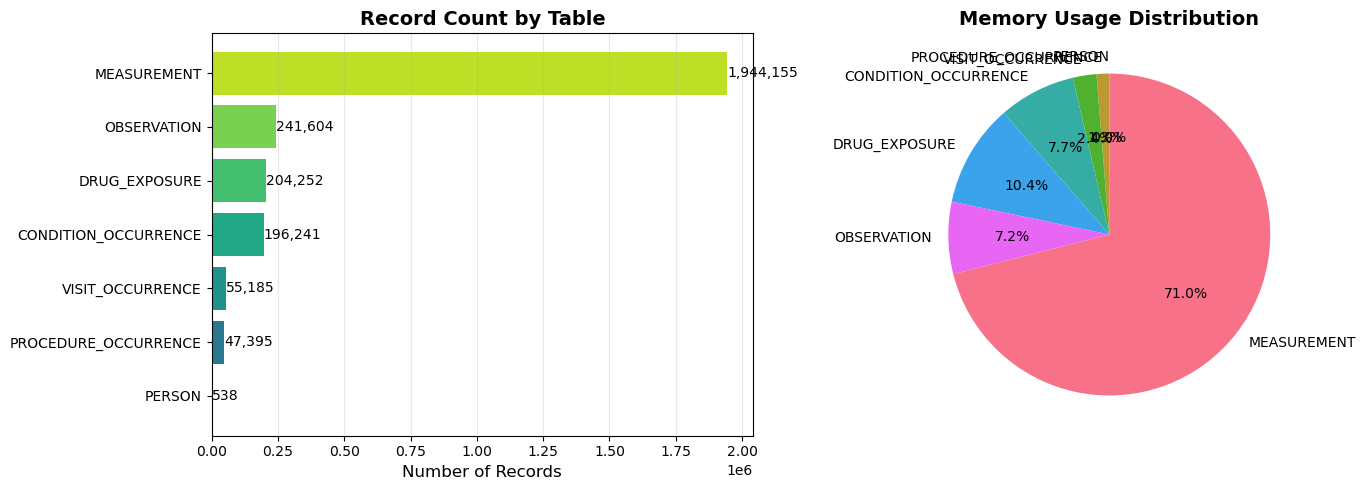

In [24]:
# Record count bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sort tables by row count
sorted_stats = stats_df.sort_values('Rows', ascending=True)

# Bar chart of row counts
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_stats)))
bars = ax1.barh(sorted_stats['Table'], sorted_stats['Rows'], color=colors)
ax1.set_xlabel('Number of Records', fontsize=12)
ax1.set_title('Record Count by Table', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar, value in zip(bars, sorted_stats['Rows']):
    ax1.text(value, bar.get_y() + bar.get_height()/2, f'{value:,}', 
            ha='left', va='center', fontsize=10)

# Pie chart of memory usage
memory_data = sorted_stats[sorted_stats['Memory (MB)'] > 0]
if len(memory_data) > 0:
    ax2.pie(memory_data['Memory (MB)'], 
           labels=memory_data['Table'],
           autopct='%1.1f%%',
           startangle=90)
    ax2.set_title('Memory Usage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

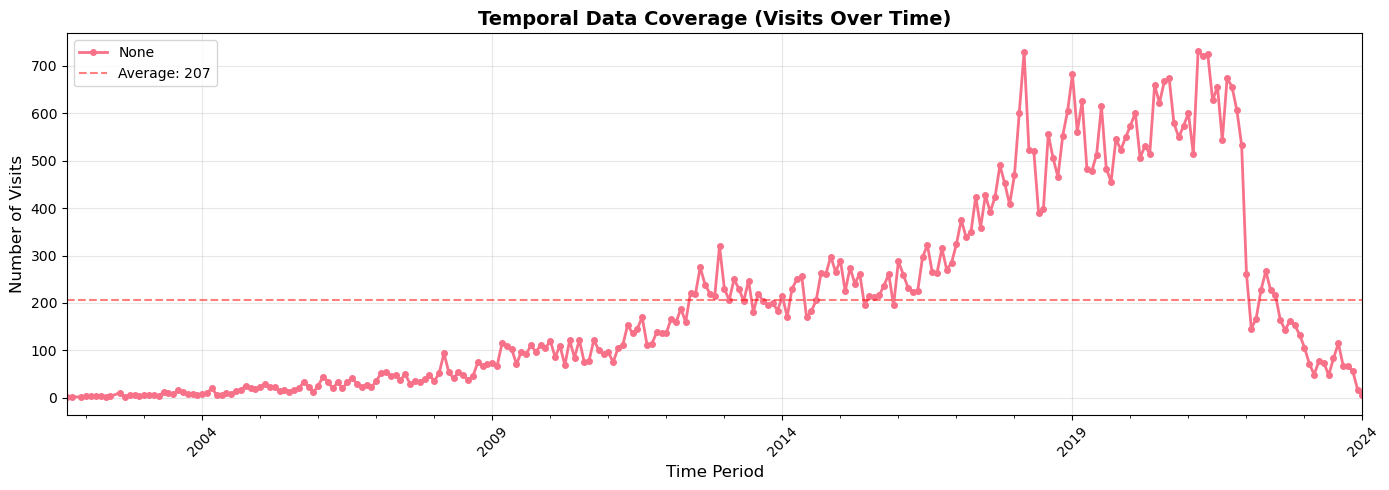

📊 Temporal Coverage Summary:
  • Date range: 2001-09 to 2024-01
  • Total months: 267
  • Average visits/month: 207
  • Peak month: 2021-03 (732 visits)


In [25]:
# Timeline visualization - data coverage over time
if 'VISIT_OCCURRENCE' in tables and len(tables['VISIT_OCCURRENCE']) > 0:
    visit_df = tables['VISIT_OCCURRENCE'].copy()
    
    # Convert dates
    visit_df['visit_start_date'] = pd.to_datetime(visit_df['visit_start_date'], errors='coerce')
    visit_df = visit_df.dropna(subset=['visit_start_date'])
    
    if len(visit_df) > 0:
        # Group by month
        visit_df['year_month'] = visit_df['visit_start_date'].dt.to_period('M')
        monthly_visits = visit_df.groupby('year_month').size()
        
        # Plot
        fig, ax = plt.subplots(figsize=(14, 5))
        monthly_visits.plot(kind='line', ax=ax, linewidth=2, marker='o', markersize=4)
        ax.set_xlabel('Time Period', fontsize=12)
        ax.set_ylabel('Number of Visits', fontsize=12)
        ax.set_title('Temporal Data Coverage (Visits Over Time)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        avg_visits = monthly_visits.mean()
        ax.axhline(y=avg_visits, color='r', linestyle='--', alpha=0.5, label=f'Average: {avg_visits:.0f}')
        ax.legend()
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"[STATS] Temporal Coverage Summary:")
        print(f"  • Date range: {monthly_visits.index.min()} to {monthly_visits.index.max()}")
        print(f"  • Total months: {len(monthly_visits)}")
        print(f"  • Average visits/month: {avg_visits:.0f}")
        print(f"  • Peak month: {monthly_visits.idxmax()} ({monthly_visits.max():,} visits)")

## Part 4: Quality Report Summary

In [26]:
# Generate comprehensive quality report
print("[REPORT] DATA QUALITY REPORT SUMMARY")
print("="*60)

# Collect all quality metrics
quality_metrics = {
    'Total Tables Loaded': len(tables),
    'Missing Tables': len(missing_tables),
    'Total Records': stats_df['Rows'].sum(),
    'Total Unique Patients': tables['PERSON']['person_id'].nunique() if 'PERSON' in tables else 0,
    'Data Size (MB)': stats_df['Memory (MB)'].sum(),
    'Tables with Missing Data': sum(1 for name, df in tables.items() if df.isnull().any().any()),
}

# Display metrics
for metric, value in quality_metrics.items():
    if isinstance(value, float):
        print(f"{metric:.<30} {value:,.1f}")
    else:
        print(f"{metric:.<30} {value:,}")

print("\n" + "="*60)

📋 DATA QUALITY REPORT SUMMARY
Total Tables Loaded........... 7
Missing Tables................ 0
Total Records................. 2,689,370
Total Unique Patients......... 538
Data Size (MB)................ 862.1
Tables with Missing Data...... 7



In [27]:
# Identify critical issues and provide recommendations
print("[WARNING]  CRITICAL ISSUES & RECOMMENDATIONS")
print("="*60)

issues = []
recommendations = []

# Check for critical issues
if missing_tables:
    issues.append(f"Missing {len(missing_tables)} required tables: {', '.join(missing_tables)}")
    recommendations.append("Ensure all required OMOP tables are present before running pipeline")

if 'PERSON' in tables:
    person_df = tables['PERSON']
    if len(person_df) == 0:
        issues.append("PERSON table is empty")
        recommendations.append("Load patient data before proceeding")
    elif person_df['person_id'].duplicated().any():
        issues.append("Duplicate person_ids found")
        recommendations.append("Review and deduplicate PERSON table")

# Check for excessive missing data
for name, df in tables.items():
    null_pct = (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100) if len(df) > 0 else 0
    if null_pct > 50:
        issues.append(f"{name} has {null_pct:.1f}% missing data")
        recommendations.append(f"Review data quality for {name} table")

# Display results
if issues:
    print("\n[CRITICAL] Issues Found:")
    for i, issue in enumerate(issues, 1):
        print(f"  {i}. {issue}")
    
    print("\n[TIP] Recommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")
else:
    print("\n[OK] No critical issues found!")
    print("\nYour data appears ready for the CRISP pipeline.")
    print("\nNext steps:")
    print("  1. Run data validation: python data_preparation/validate_data.py")
    print("  2. Execute pipeline: python pipeline_modules/run_all_module.py")

print("\n" + "="*60)
print("Report generated successfully")

⚠️  CRITICAL ISSUES & RECOMMENDATIONS

✅ No critical issues found!

Your data appears ready for the CRISP pipeline.

Next steps:
  1. Run data validation: python data_preparation/validate_data.py
  2. Execute pipeline: python pipeline_modules/run_all_module.py

Report generated successfully
